In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = '/home/jarvis/ML/asl-alphabet'
TRAIN_DIR = os.path.join(DATA_DIR,'train_images')
VAL_DIR = os.path.join(DATA_DIR,'val_images')
train_gen = ImageDataGenerator(rescale = 1./255)

In [3]:
IMG_SIZE = 160
train_data = train_gen.flow_from_directory(
    directory = TRAIN_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
)
val_data = train_gen.flow_from_directory(
    directory = VAL_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
)

Found 72500 images belonging to 29 classes.
Found 14500 images belonging to 29 classes.


In [4]:
print(train_data)

In [5]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE,3)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                              include_top = False,
                                              weights = 'imagenet')

In [6]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [7]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(29,activation = 'softmax')
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [8]:
lr = 0.0001
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 29)                37149     
Total params: 2,295,133
Trainable params: 37,149
Non-trainable params: 2,257,984
_________________________________________________________________


In [9]:
initial_epochs = 8
validation_steps=20

loss0,accuracy0 = model.evaluate(val_data, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 8s 385ms/step - loss: 4.0209 - accuracy: 0.0266
initial loss: 4.02
initial accuracy: 0.03


In [10]:
import time
NAME = 'mobilenetv2-{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

In [11]:
history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data,callbacks=[tensorboard])

Epoch 1/8
2266/2266 [==============================] - 1421s 627ms/step - loss: 1.1878 - accuracy: 0.7530 - val_loss: 0.5070 - val_accuracy: 0.9221
Epoch 2/8
2266/2266 [==============================] - 1103s 487ms/step - loss: 0.3583 - accuracy: 0.9466 - val_loss: 0.2626 - val_accuracy: 0.9592
Epoch 3/8
2266/2266 [==============================] - 953s 420ms/step - loss: 0.2078 - accuracy: 0.9703 - val_loss: 0.1709 - val_accuracy: 0.9761
Epoch 4/8
2266/2266 [==============================] - 996s 440ms/step - loss: 0.1409 - accuracy: 0.9805 - val_loss: 0.1231 - val_accuracy: 0.9837
Epoch 5/8
2266/2266 [==============================] - 1013s 447ms/step - loss: 0.1036 - accuracy: 0.9867 - val_loss: 0.0946 - val_accuracy: 0.9870
Epoch 6/8
2266/2266 [==============================] - 1004s 443ms/step - loss: 0.0799 - accuracy: 0.9904 - val_loss: 0.0753 - val_accuracy: 0.9906
Epoch 7/8
2266/2266 [==============================] - 978s 431ms/step - loss: 0.0640 - accuracy: 0.9931 - val_los

In [12]:
model.save('mobnetv2.h5')

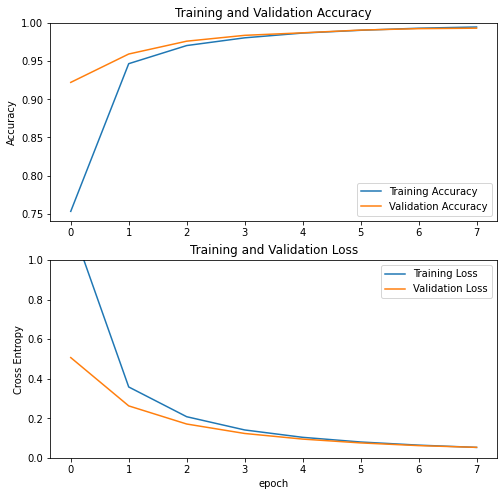

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()